# OCNG/ATMO 651 Final Project: Linear Inverse Model of Tropical Sea Surface Temperatures

## Dataset
NCEP/NCAR Reanalysis monthly-mean SST from 1948-01 to 2017-09. The dataset are divided into two parts: the training set and the test set. The training set contains 1948-01 to 1999-12, and the test set contains 2000-01 to 2017-09.

## Steps

1. Smooth SST anomalies (SSTAs) using a 3-month running mean and then perform an EOF analysis on the smoothed SSTAs;
2. Reconstruct and truncate SSTAs using leading EOFs and the corresponding principal component time series as, $T(t)=\sum _{i=1}^M P_(t) E_i$, where $E_i$ is the $i$-th EOF, $P_i(t)$ is the $i$-th principal component, $M$ is the number of EOFs used to represent $T(t)$. Typically, $M$ is less than 10 and can be determined by the explained variance, say 90%, by the first $M$ EOFs;
3. Compute covariance and lag-covariance matrix in EOF space, $ \check{C} = \overline{P(t)P'(t)}$, $\check{C}_{\Delta t} = \overline{P(t+\Delta t)P'(t)} $ (overline stands for time average), where $\check{C}$ and $\check{C}_{\Delta t}$ are the covariance and lag-covariance matrix in EOF space, $P(t)_{M\times 1}$ is a state vector of $P_i(t)$ and $P'(t)$ is its transpose, i.e., $P'(t) = [P_1(t), P_2(t), …, P_M(t)]_{1\times M}$;
4. Compute the propagator in EOF space, $G=\check{C}_{\Delta t} \check{C}^{-1}$, where the lag $\Delta t$ can be taken to be 7 months (see Penland and Magorian (1993)) and $G$ has $M\times M$ dimension;
5. Take an initial SSTA state vector $T$ at any $t_0$, regress $T(t_0)$ onto $E_i$ to determine $P_i(t_0)$ and then form $P(t_0)$;
6. Make SST forecast in EOF space from $t_0$ to $t_n$: $P(t_n) = G^{\frac{t_n-t_0}{\Delta t}}P(t_0)$;
7. Transform the forecast in EOF space, $P(t_n)$, back to the physical space: $T(t_n)=\sum _{i=1}^M P(t_n) E_i$.


### 1. Smooth SSTAs

Smooth SST anomalies (SSTAs) using a 3-month running mean.

In [3]:
import numpy.linalg as la
import xarray as xr
import numpy as np
from rich import print

def get_anomaly(x):
    """Remove the seasonal cycle from the data.
    Params: x (numpy array): data with time dimension
    Returns: x (numpy array): data with seasonal cycle removed
    """
    nt, ny, nx = x.shape
    # if nt is not a multiple of 12, remove the last few months
    if nt % 12 != 0:
        x = x[:-(nt % 12),:,:]
    nt, ny, nx = x.shape
    x = x.reshape(nt//12, 12, ny, nx)
    # seasonal mean
    x_mean = x.mean(axis=0, keepdims=True)
    # remove seasonal cycle
    x = x - x_mean
    # reshape time dimension
    x = x.reshape(nt, ny, nx)
    return x

def running_mean(x, m):
    """Compute the running mean of x along the first dimension.
    Params: x (numpy array): data
            m (int): half of the window size
    Returns: x (numpy array): data with running mean
    """
    # reference:
    # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    nt, ny, nx = x.shape
    x_rm = np.zeros_like(x)
    # pad the data along the dimension dim with m elements
    pad_width = [(0, 0)]*x.ndim
    pad_width[0] = (m, m)
    x = np.pad(x, pad_width, mode='edge')
    # compute the running mean
    for j in range(ny):
        for i in range(nx):
            x_rm[:,j,i] = np.convolve(x[:,j,i], np.ones(2*m+1)/float(2*m+1), mode='valid')
    return x_rm

# read in the data
dir = "../NCEP_monthly_mean_data/"
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
sst_da, grid_da = sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
sst_da = sst_da.reindex(lat=sst_da.lat[::-1])
grid_da = grid_da.reindex(lat=grid_da.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 100E-60W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 100, 300
sst = sst_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid_da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
lat, lon = sst.lat.values, sst.lon.values
print("Lat min: ", lat_min, "Lat max: ", lat_max)
print("Lon min: ", lon_min, "Lon max: ", lon_max)
time = sst.time.values
# get the data as numpy arrays
sst, grid = sst.values, grid.values
grid = grid[0,:,:]
# normalize the data
sst_anom = get_anomaly(sst)
# get 3-month running mean with a window size of 3 (half window size is 1)
sst_anom = running_mean(sst_anom, 1)
# mask out the land
sst_anom[:, grid == -1] = 0
print("SST anomaly training data shape: ", sst_anom.shape)
# get test data
sst_test = sst_da.sel(time=slice("2000", "2019"), lon=slice(lon_min, lon_max))
sst_test = sst_test.values
sst_test_anom = get_anomaly(sst_test)
sst_test_anom = running_mean(sst_test_anom, 1)
sst_test_anom[:, grid == -1] = 0
print("SST anomaly test data shape: ", sst_test_anom.shape)

Lat min:  -30 Lat max:  30

Lon min:  100 Lon max:  300

SST anomaly training data shape: 
(624, 32, 107)

SST anomaly test data shape: 
(204, 32, 107)

### 2. EOF decomposition and reconstruction

* Perform an EOF (empirical orthogonal functions) analysis on the smoothed SSTAs;
* Reconstruct and truncate SSTAs using $m$ leading EOFs and the corresponding principal component time series as $T(t) = \sum_{i=1}^m P_i(t) E_i$, where $P_i(t)$ is the $i$-th principal component time series and $E_i$ is the $i$-th EOF.

In [4]:
# reference: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
from eofs.standard import Eof
# compute the first m EOFs
m = 20
wgt = np.cos(np.deg2rad(lat))[np.newaxis,:,np.newaxis]
solver = Eof(sst_anom) #, weights=wgt)
eofs = solver.eofsAsCovariance(neofs=m)
pcs = solver.pcs(npcs=m, pcscaling=1)
explained_variance = solver.varianceFraction()
print("eofs shape: ", eofs.shape)
print("pcs shape: ", pcs.shape)
print("explained variance shape: ", explained_variance.shape)
# print first 20 explained variance and cumulative explained variance
print("explained variance: ", explained_variance[:20])
print("cumulative explained variance: ", explained_variance[:20].cumsum())

eofs shape: 
(20, 32, 107)

pcs shape: 
(624, 20)

explained variance shape: 
(624,)

explained variance:  [0.42042282 0.09684107 0.08963736 0.04160299 0.03739775 0.02644188
 0.02405674 0.021693   0.01972148 0.0170013  0.01547117 0.01243807
 0.01131058 0.00986307 0.00938475 0.00866209 0.00849391 0.00766332
 0.0075213  0.0063231 ]

cumulative explained variance:  [0.42042282 0.5172639  0.6069012  0.6485042  0.68590194 
0.7123438
 0.73640054 0.75809354 0.77781504 0.7948164  0.81028754 0.8227256
 0.8340362  0.84389925 0.853284   0.8619461  0.87044    0.8781033
 0.8856246  0.8919477 ]

As we can see, the first 10 EOFs can explain 79.48% of the variance of the SSTAs, and the first 20 EOFs can explain 89.19% of the variance of the SSTAs.

In [5]:
# import necessary modules for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

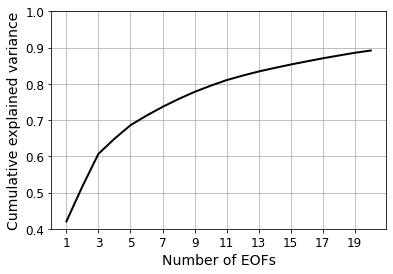

In [8]:
# make a plot of the cumulative explained variance as a function of the number of EOFs
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(1, m+1), explained_variance[:m].cumsum(), 'k-', lw=2)
ax.set_xlabel("Number of EOFs", fontsize=14)
ax.set_ylabel("Cumulative explained variance", fontsize=14)
ax.set_xticks(np.arange(1, m+1, 2))
ax.set_yticks(np.arange(0.4, 1.1, 0.1))
ax.set_ylim(0.4, 1)
ax.tick_params(labelsize=12)
ax.grid()
plt.show()
fig.savefig("./report/figures/cumulative_explained_variance.png", dpi=300, bbox_inches='tight')

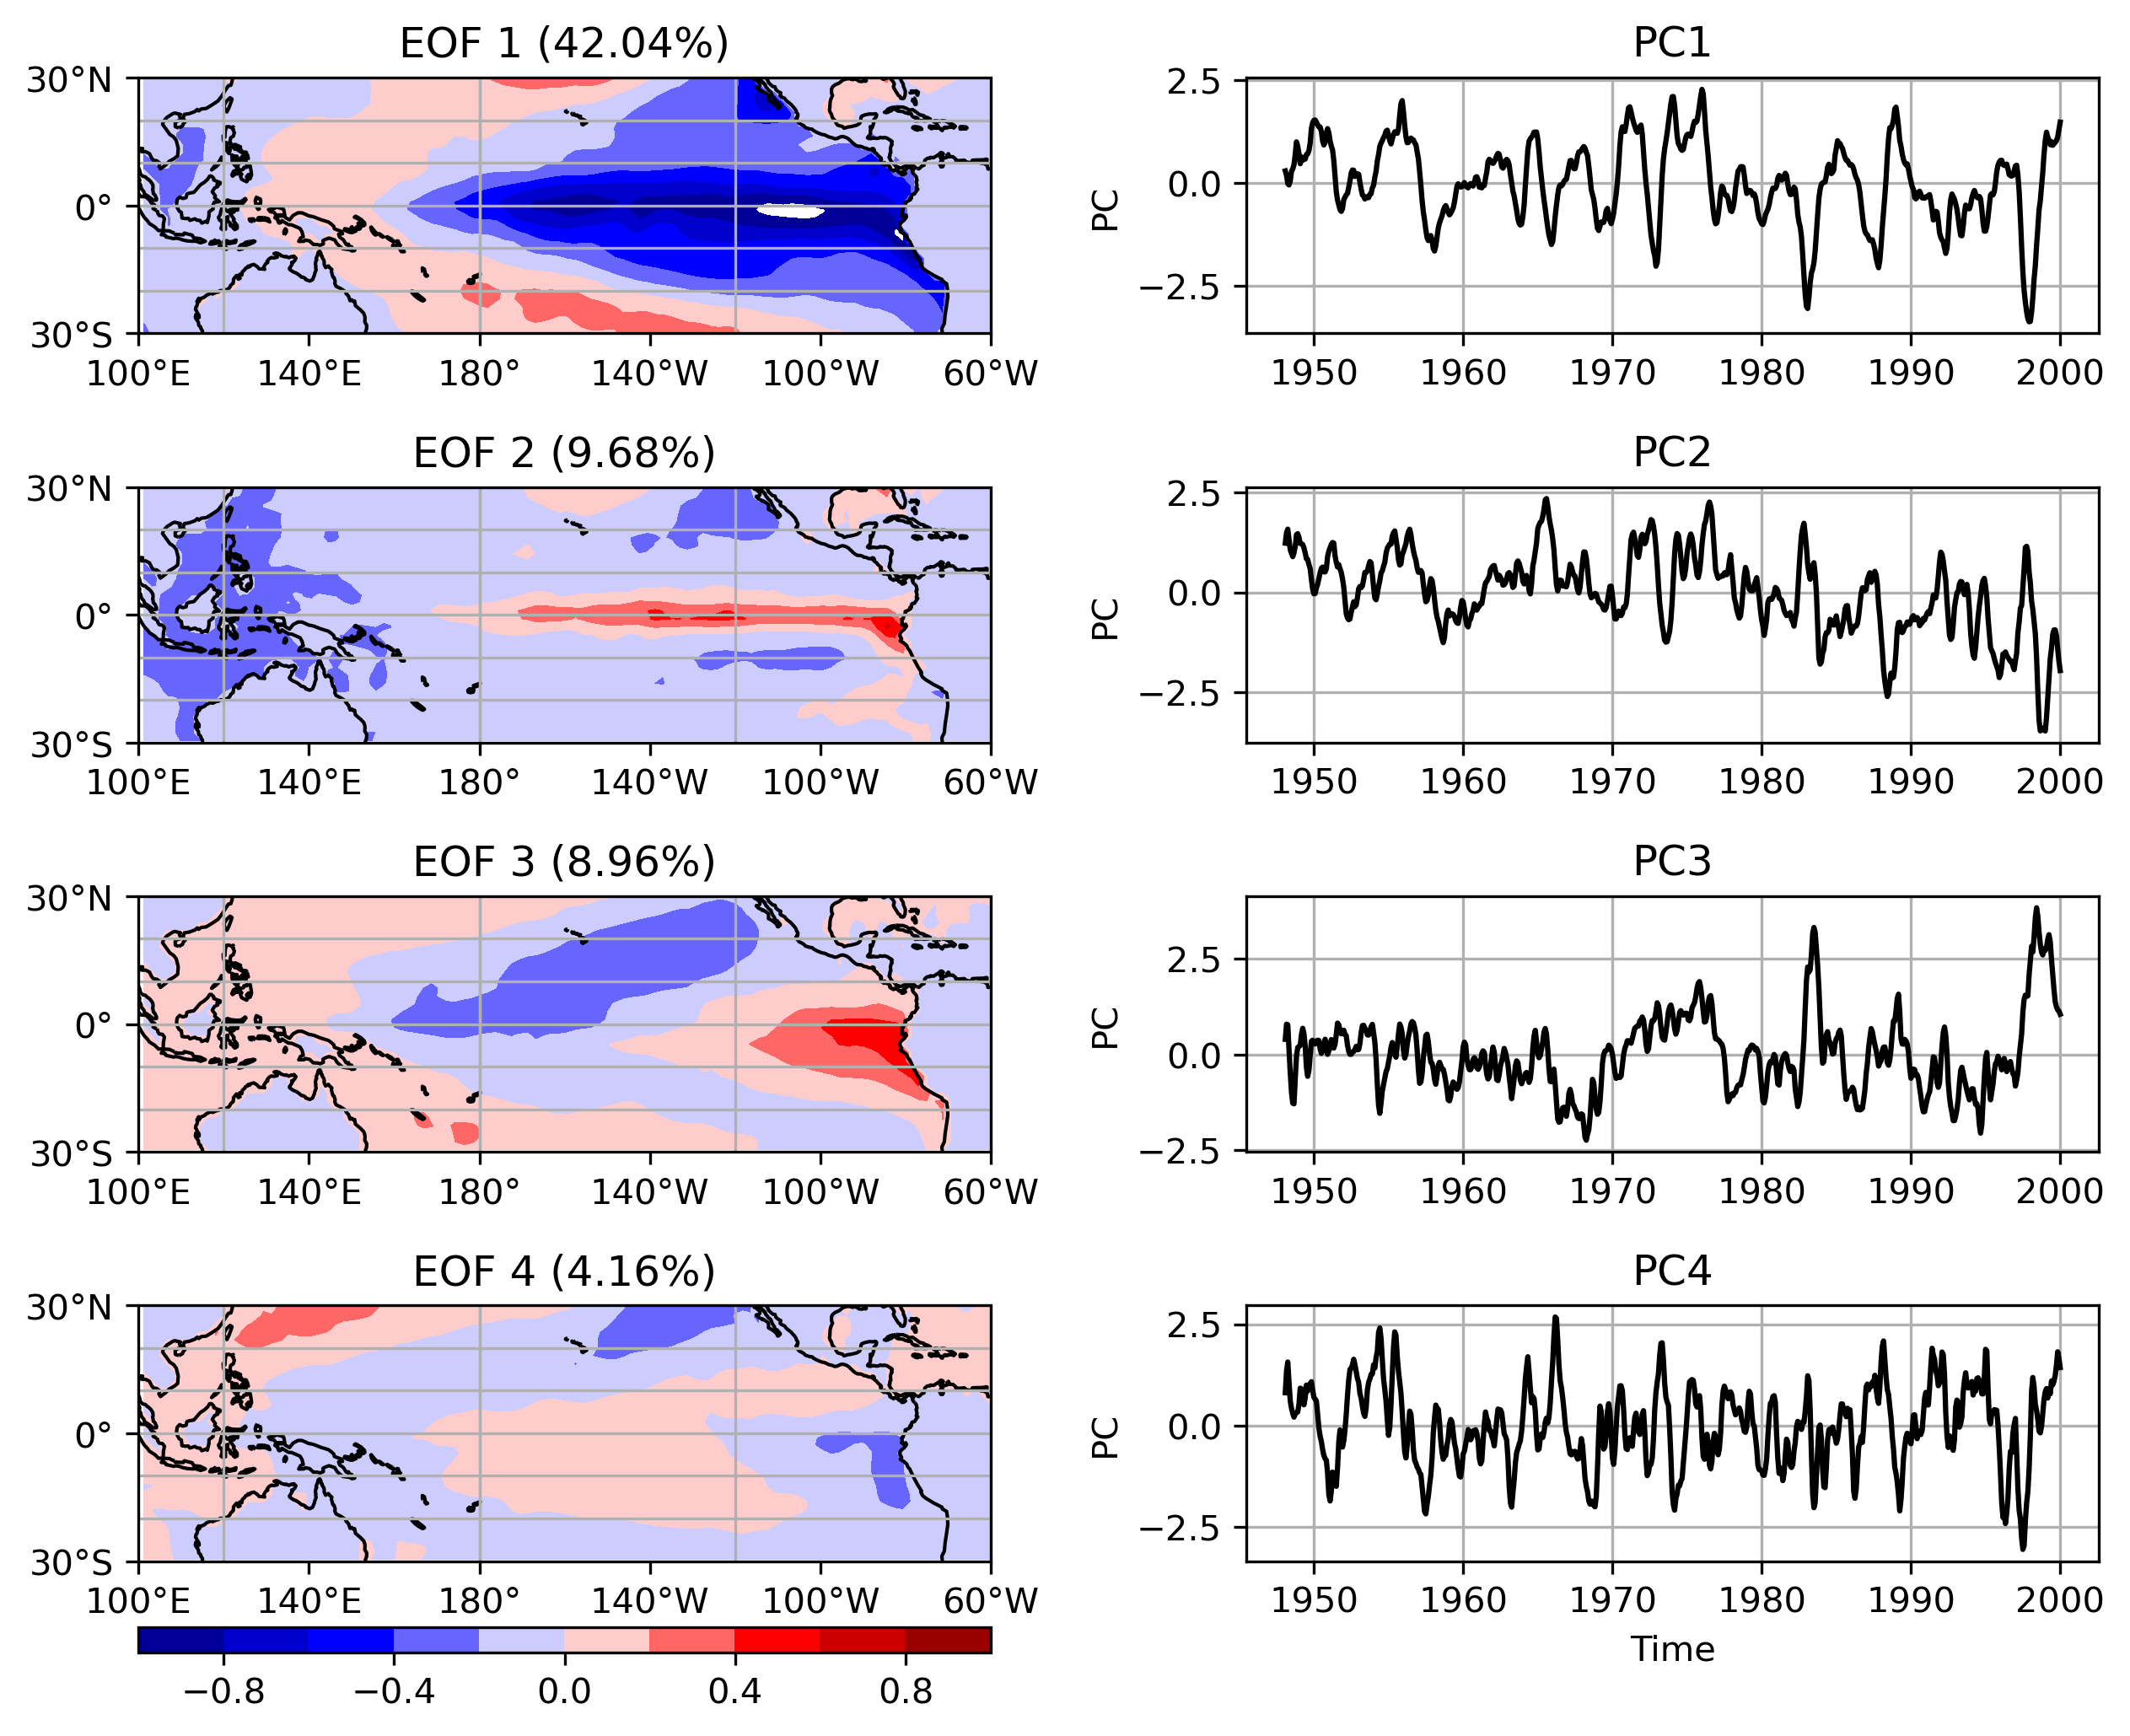

In [9]:
# plot the first 4 EOFs and PCs
# set up the figure, left column for EOFs, right column for PCs
plot_modes = 4
fig = plt.figure(figsize=(10, 10), dpi=300)
# set up the projection
projection = ccrs.PlateCarree(central_longitude=180)
# set up the axes
axes = np.empty((plot_modes, 2), dtype=object)
for i in range(plot_modes):
    axes[i,0] = fig.add_subplot(plot_modes, 2, 2*i+1, projection=projection)
    axes[i,1] = fig.add_subplot(plot_modes, 2, 2*i+2)
# cftime to float
time_fl = [t.year + t.month/12 for t in time]
# plot the first 4 EOFs
for i in range(plot_modes):
    ax = axes[i,0]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # plot the EOF
    im = ax.contourf(lon, lat, eofs[i,:,:], levels=np.linspace(-1, 1, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
    # add coastlines
    ax.coastlines()
    # add gridlines
    ax.gridlines()
    # add title
    ax.set_title(f"EOF {i+1} ({explained_variance[i]*100:.2f}%)")
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar
    if i == plot_modes - 1:
        cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
        fig.colorbar(im, cax=cax, orientation='horizontal')
    aspect_ratio = 1/ax.get_data_ratio()
    # plot the PC
    ax = axes[i,1]
    # set aspect ratio
    ax.plot(time_fl, pcs[:,i], color='k')
    ax.set_title("PC" + str(i+1))
    if i == plot_modes-1:
        ax.set_xlabel("Time")
    ax.set_ylabel("PC")
    # add gridlines
    ax.grid()
    ax.set_aspect(60/200/ax.get_data_ratio())
# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=-0.4)
# show and save the figure
plt.show()
fig.savefig("./report/figures/EOFs_PCs.png", dpi=300, bbox_inches='tight')

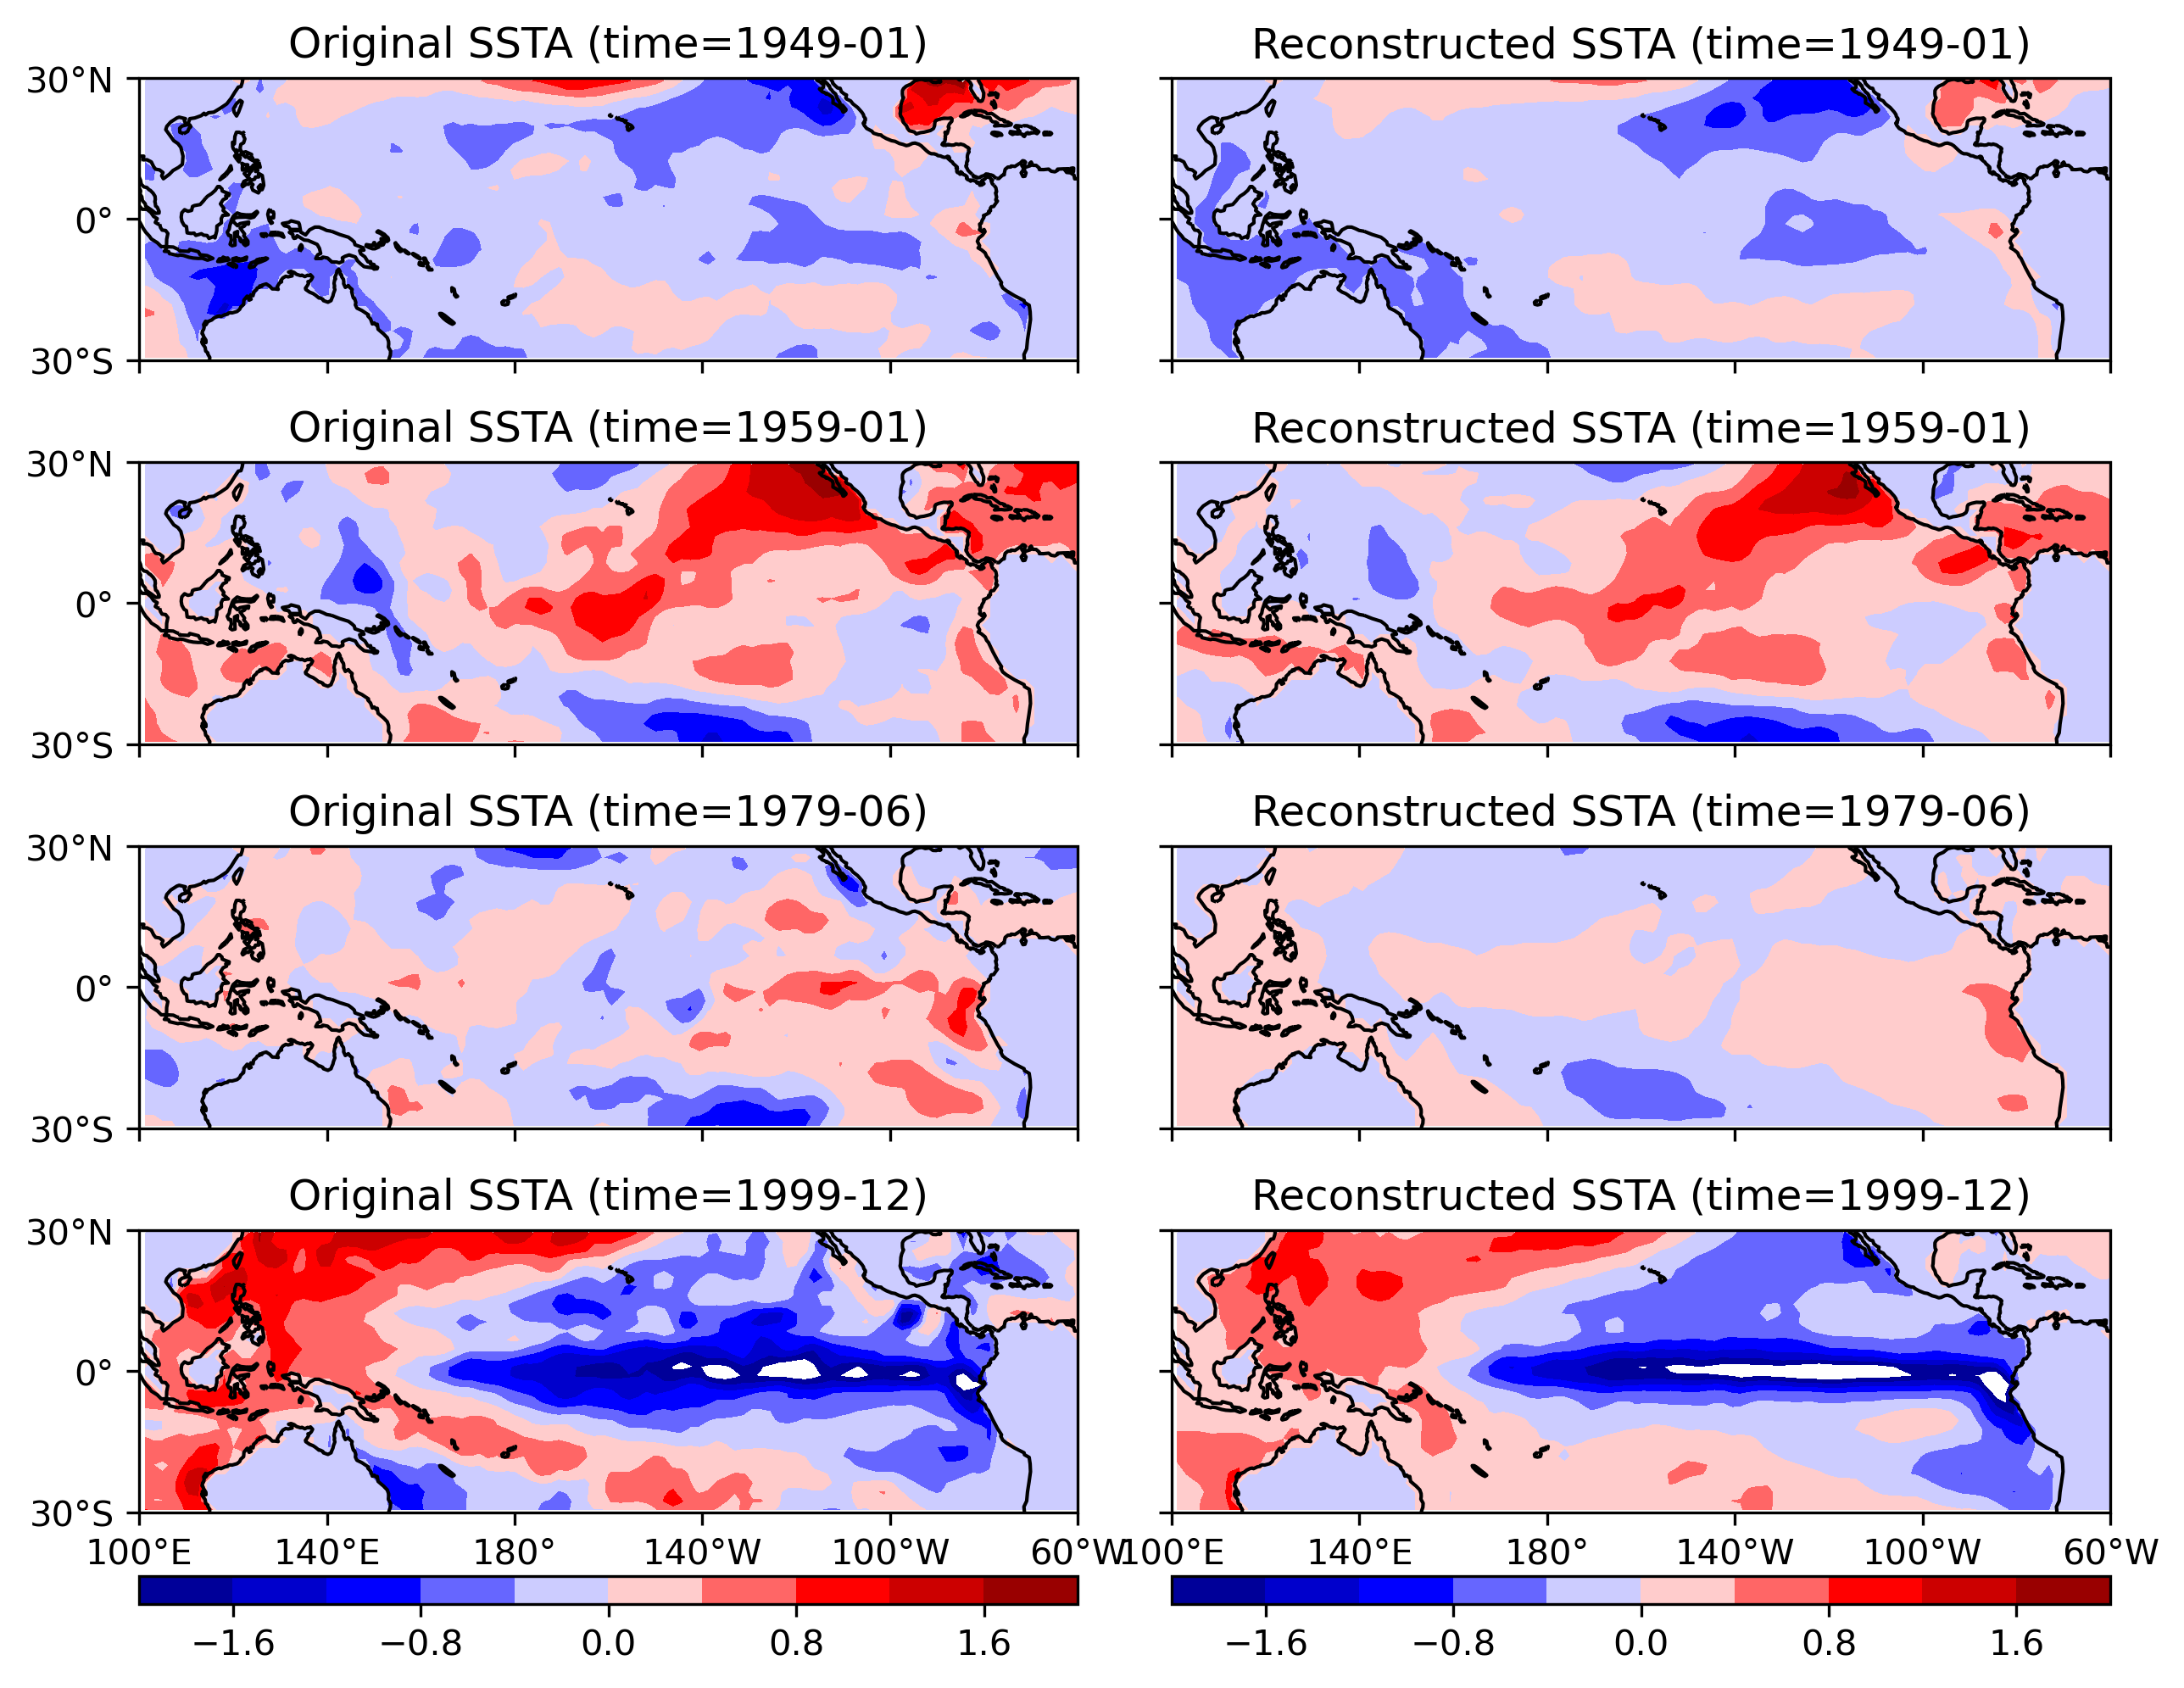

In [10]:
import cftime
# reconstruct the first m EOFs, can also use the solver.reconstructedField()
m = 10
sst_recon = pcs[:, :m] @ (eofs[:m, :, :].reshape(m, -1))
sst_recon = sst_recon.reshape(-1, grid.shape[0], grid.shape[1])
# plot the original SST and the reconstructed SST at 4 time steps
plot_step = 4
time_steps = [cftime.DatetimeGregorian(1949, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1959, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1979, 6, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1999, 12, 1, 0, 0, 0, 0)]
# get time index
time_idx = [np.where(time == t)[0][0] for t in time_steps]
fig, axes = plt.subplots(plot_step, 2, figsize=(10, 10),
                            subplot_kw={'projection': projection},
                            dpi=300)
for i in range(plot_step):
    year, month = time_steps[i].year, time_steps[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_anom[time_idx[i],:,:], levels=np.linspace(-2, 2, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Original SSTA (time={year}-{month:02d})")
        else:
            im = ax.contourf(lon, lat, sst_recon[time_idx[i],:,:], levels=np.linspace(-2, 2, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Reconstructed SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == plot_step - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == plot_step - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.5)
plt.show()
fig.savefig("./report/figures/reconstruct_ssta.png", dpi=300, bbox_inches='tight')


### 3. Compute covariance and lag-covariance matrix in EOF space

* Compute covariance ($\hat{C}$) and lag-covariance matrix ($\hat{C}_{\Delta t}$) in EOF space, where $\Delta t$ is the time lag. $\hat{C} = \frac{1}{N} \sum_{t=1}^N P(t)P(t)^T$ and $\hat{C}_{\Delta t} = \frac{1}{N-\Delta t} \sum_{t=1}^{N-\Delta t} P(t)P(t+\Delta t)^T$.

In [33]:
m = 10
# covariance of the first m PCs
PC_cov = pcs[:,:m].T @ pcs[:,:m] / (len(time))
# lag-covariance of the first m PCs (lag=7)
lag = 7
PC_lag_cov = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        PC_lag_cov[i,j] = np.mean(pcs[:-lag,i] * pcs[lag:,j])

# print the shapes of the matrices
print("Shape of the covariance matrix:", PC_cov.shape)
print("Shape of the lag-covariance matrix:", PC_lag_cov.shape)

Shape of the covariance matrix:
(10, 10)

Shape of the lag-covariance matrix:
(10, 10)

### 4. Compute propagator matrix

* Compute propagator matrix: ($\hat{G}$) = $\hat{C}_{\Delta t}\hat{C}^{-1}$ in EOF space.

In [60]:
# Propagator matrix: G = PC_lag_cov @ inv(PC_cov)
G = PC_lag_cov @ np.linalg.inv(PC_cov)
# print the shape of the propagator matrix
print(G)
print("Shape of the propagator matrix:", G.shape)

[[ 0.48637911  0.52435026 -0.03141356 -0.28282963  0.04260896  0.07040888
   0.22027949  0.12510945 -0.15483603  0.02030365]
 [-0.08129336  0.51566451  0.00493658  0.15098906 -0.00484569 -0.28469081
  -0.14544944 -0.0217711   0.11023552 -0.09070343]
 [ 0.19975404 -0.16183957  0.59773581  0.05959727 -0.03448022  0.06099291
  -0.02645224 -0.01106014 -0.02398493 -0.11995039]
 [ 0.33011558  0.03198383 -0.03969555  0.23704767 -0.1910102   0.11610347
   0.0549647  -0.05375094  0.14968885 -0.03707138]
 [ 0.19613413  0.01076359  0.03464857  0.09724937  0.4869897  -0.30133762
  -0.11182603  0.1783259  -0.00670836 -0.00116785]
 [-0.09225614 -0.04851098  0.01790794  0.26940368 -0.14397288  0.16252731
   0.06664484 -0.10879566 -0.26044302  0.05401954]
 [-0.21855108  0.06723693  0.09170828  0.10861238 -0.06757296  0.00240204
   0.48230384  0.08632049 -0.06839719  0.05080943]
 [-0.23009575  0.16314985  0.07090403 -0.03355557  0.1563969  -0.0560339
   0.0892081   0.08142719 -0.02055505  0.00217558]
 [-0.07656638  0.01726    -0.07954981  0.04458614  0.23335047 -0.03951804
  -0.08104841 -0.04045151 -0.17434444 -0.19160515]
 [ 0.10973685 -0.15285549  0.04604742 -0.20168705 -0.11939993 -0.14137602
   0.19300737  0.10866802 -0.10388073  0.31488648]]

Shape of the propagator matrix:
(10, 10)

### 5. Regress initial SSTA onto EOF space

* Take an initial SSTA state vector $T$ at any $t_0$, regress $T(t_0)$ onto $E_i$ to determine
$P_i(t_0)$ and then form $P(t_0)$.

In [45]:
T_t0 = sst_test_anom[0,:,:].flatten()
# determine PCs at time t0
pcs_t0 = []
m = 10
for i in range(m):
    eof_i = eofs[i,:,:].flatten()
    # linear regression
    coef, intercept = np.polyfit(eof_i, T_t0, 1)
    pcs_t0.append(coef)
pcs_t0 = np.array(pcs_t0)
print("Values of leading PCs at time t0:", pcs_t0)

1.4958267230224096 0.039257711309897844

-1.9093600165998457 -0.35965106675752645

1.023474202039385 -0.20411078016712275

-0.6088067726670795 -0.20830356735837316

-0.6001436661658797 -0.18031627423211907

2.500007113517479 -0.19425325904329968

-0.707390185883615 -0.1978398936795909

2.002474101809238 -0.23819561454093113

-0.19612283360040322 -0.20042094665774174

-0.11541310893793644 -0.19984288109318182

Values of leading PCs at time t0: [ 1.49582672 -1.90936002  1.0234742  -0.60880677 
-0.60014367  2.50000711
 -0.70739019  2.0024741  -0.19612283 -0.11541311]

### Make SST forecast in EOF space
* Make SST forecast in EOF space from $t_0$ to $t_n$: $P(t_n) = G^{\frac{t_n-t_0}{\Delta t}}P(t_0)$;


In [58]:
# make forecast for 9 months
forecast_months = 9
# initialize the forecast array
pcs_tn = np.zeros((forecast_months, m))
print(pcs_t0.shape)
for i in range(forecast_months):
    pcs_tn[i,:] = G ** ((i+1)/7) @ pcs_t0
print("Values of leading PCs at time tn:", pcs_tn)
print("Shape of the forecast leading PCs:", pcs_tn.shape)

(10,)

<ipython-input-58-aa857fb360a7>:7: RuntimeWarning: invalid value encountered in power
  pcs_tn[i,:] = G ** ((i+1)/7) @ pcs_t0


Values of leading PCs at time tn: [[        nan         nan         nan         nan         
nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [ 0.13958272 -1.85373952  1.37157943  0.4810813  -0.35887495  0.08150298
  -0.54177061 -0.69291251 -0.46224988  0.40924104]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]]

Shape of the forecast leading PCs:
(9, 10)

### Transform the forecast in EOF space

* Transform the forecast in EOF space, $P(t_n)$, back to the physical space: $T(t_n)=\sum _{i=1}^M P(t_n) E_i$.

In [40]:
# transform the forecasted PCs to SSTA
sst_forecast = np.sum(pcs_tn[:, :, np.newaxis, np.newaxis] * eofs[:m, :, :], axis=1)
print("Shape of the forecasted SSTA:", sst_forecast.shape)

Shape of the forecasted SSTA:
(9, 32, 107)

### Plot the forecast SSTA
* Plot the forecast SSTA from 2000-02 to 2009-10 and compare it with the observed SSTA.

All data are nan for time 2000-02

<ipython-input-51-a5ae108d59e3>:23: RuntimeWarning: All-NaN slice encountered
  min_sst = np.nanmin(plot_sst)
<ipython-input-51-a5ae108d59e3>:24: RuntimeWarning: All-NaN slice encountered
  max_sst = np.nanmax(plot_sst)
c:\Users\liujj\miniconda3\envs\TC\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Users\liujj\miniconda3\envs\TC\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


All data are nan for time 2000-03

All data are nan for time 2000-04

All data are nan for time 2000-05

All data are nan for time 2000-06

All data are nan for time 2000-07

All data are nan for time 2000-09

All data are nan for time 2000-10

ValueError: Axis limits cannot be NaN or Inf

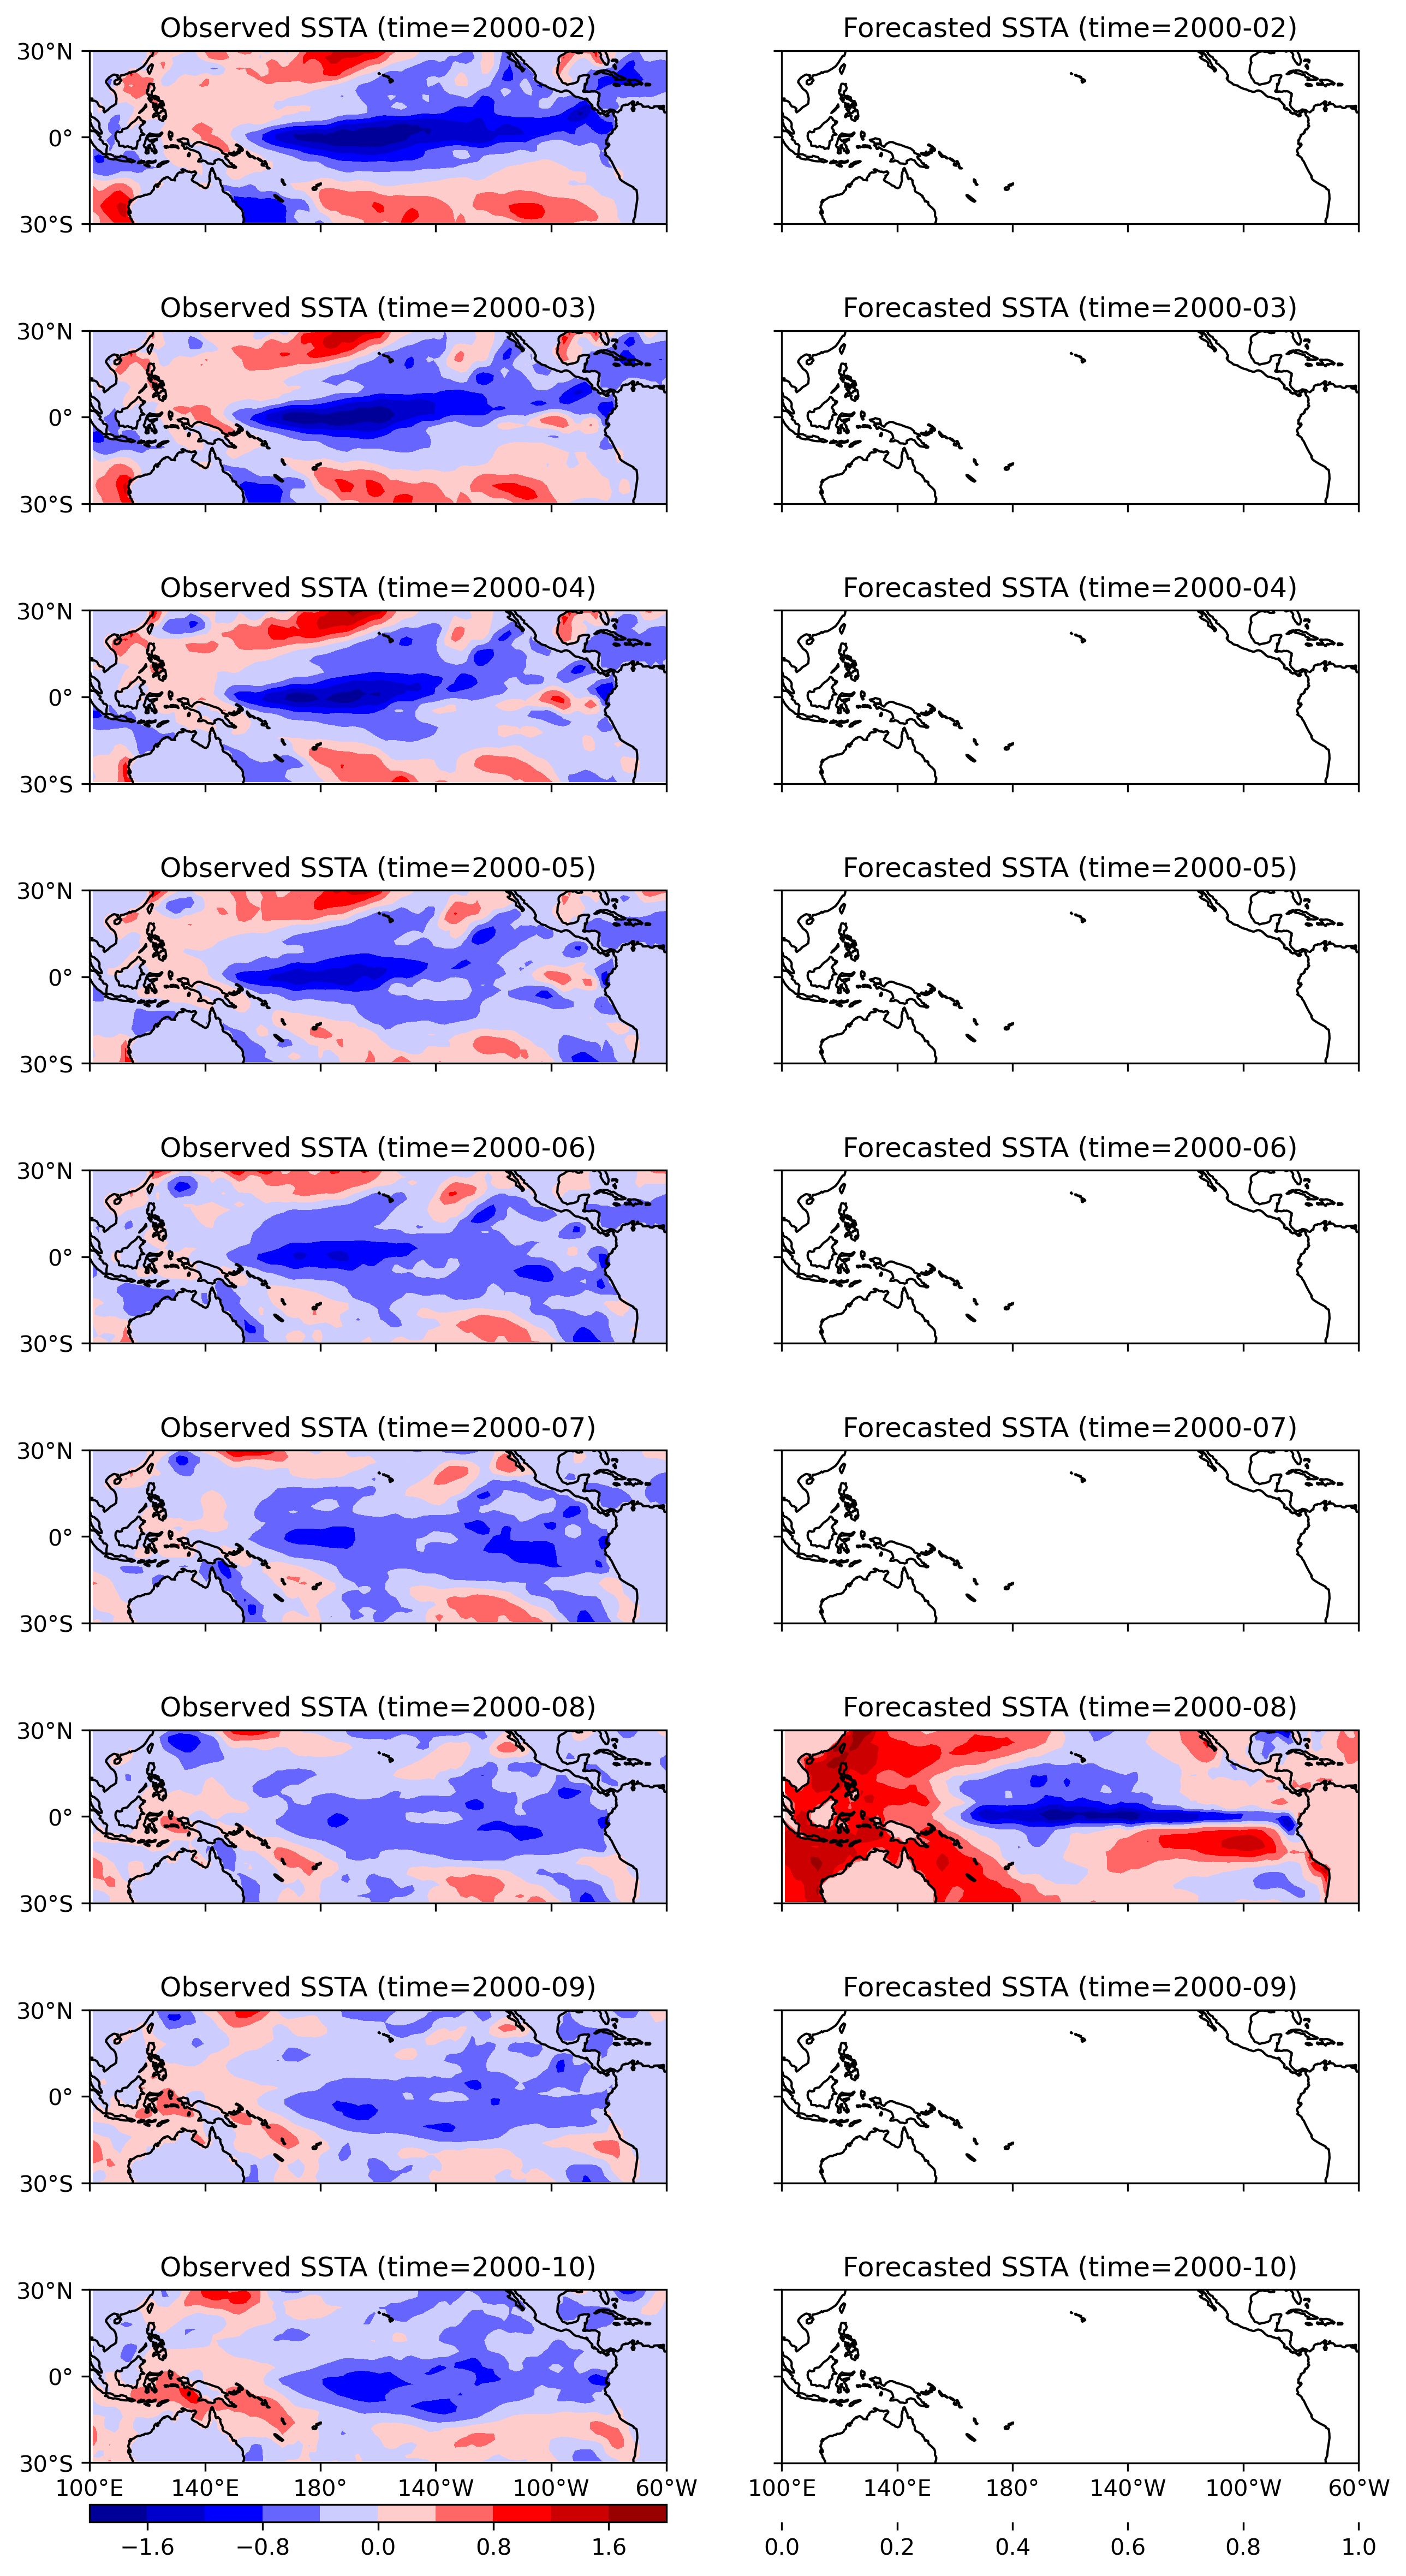

In [51]:
forecast_times = xr.cftime_range(start=cftime.DatetimeGregorian(2000, 2, 1, 0, 0, 0, 0), 
                            periods=forecast_months, freq='MS')
# plot the forecasted SSTA
projection = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(forecast_months, 2, figsize=(10, 20),
                            subplot_kw={'projection': projection},
                            dpi=300)
for i in range(forecast_months):
    year, month = forecast_times[i].year, forecast_times[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_test_anom[i+1,:,:], levels=np.linspace(-2, 2, 11), 
                            cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Observed SSTA (time={year}-{month:02d})")
        else:
            plot_sst = sst_forecast[i,:,:]
            # check if all data are nan
            if np.all(np.isnan(plot_sst)):
                print(f"All data are nan for time {year}-{month:02d}")
            min_sst = np.nanmin(plot_sst)
            max_sst = np.nanmax(plot_sst)
            im = ax.contourf(lon, lat, plot_sst, levels=np.linspace(min_sst, max_sst, 11),
                            cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Forecasted SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == forecast_months - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == forecast_months - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.5)
plt.show()
fig.savefig("./report/figures/forecast_ssta.png", dpi=300, bbox_inches='tight')